### This notebook aims to create an Excel file that tracks usage of reactions in the new model
With rows being all reactions in the model, and columns being whether a reaction is used in different conditions (T/F), and one column indicating new reactions
- [ ] basal condition
- [ ] rich condition
- [ ] acetate condition
- [ ] anaerobic (remove oxygen) condition
- [ ] remove oxygen and add nitrate exchange

May have to rerun all conditions if we modify the homeostatic objective function. 

In [37]:
import numpy as np
import ast
import pandas as pd
import os
import matplotlib.pyplot as plt
import dill
import requests
import xmltodict
import cvxpy as cp
import itertools
import networkx as nx
import plotly.express as px

from scipy.special import logsumexp

%matplotlib inline
# sns.set(style='darkgrid', palette='viridis', context='talk')

os.chdir(os.path.expanduser('~/vEcoli'))

from ecoli.processes.metabolism_redux_classic import NetworkFlowModel, FlowResult
from ecoli.library.schema import numpy_schema, bulk_name_to_idx, listener_schema, counts
from ecoli.processes.registries import topology_registry
TOPOLOGY = topology_registry.access("ecoli-metabolism-redux")

In [38]:
# load basal new model
time = '400'
date = '2025-01-30'
experiment = 'NEW_updated_bad_rxn'
condition = 'basal'
entry = f'{experiment}_{time}_{date}'
folder = f'out/metabolism-comparison/{condition}/{entry}/'

output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba_basal = output['listeners']['fba_results']
bulk = pd.DataFrame(output['bulk'])
f = open(folder + 'agent_steps.pkl', 'rb')
agent_basal = dill.load(f)
f.close()

# load rich new model
time = '400'
date = '2025-03-07'
experiment = 'NEW'
condition = 'with_aa'
entry = f'{experiment}_{time}_{date}'
folder = f'out/metabolism-comparison/{condition}/{entry}/'

output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba_rich = output['listeners']['fba_results']
f = open(folder + 'agent_steps.pkl', 'rb')
agent_rich = dill.load(f)
f.close()

# load acetate new model
time = '400'
date = '2025-02-26'
experiment = 'NEW'
condition = 'acetate'
entry = f'{experiment}_{time}_{date}'
folder = f'out/metabolism-comparison/{condition}/{entry}/'

output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba_acetate = output['listeners']['fba_results']
bulk = pd.DataFrame(output['bulk'])
f = open(folder + 'agent_steps.pkl', 'rb')
agent_acetate = dill.load(f)
f.close()

# get commonly stored variables
metabolism_basal = agent_basal['ecoli-metabolism-redux-classic']
metabolism_rich = agent_rich['ecoli-metabolism-redux-classic']
metabolism_acetate = agent_acetate['ecoli-metabolism-redux-classic']

stoichiometry = metabolism_basal.stoichiometry.copy()
reaction_names = metabolism_basal.reaction_names
kinetic_reaction_ids = metabolism_basal.kinetic_constraint_reactions
fba_new_reaction_ids = metabolism_basal.parameters["fba_new_reaction_ids"]
fba_reaction_ids_to_base_reaction_ids = metabolism_basal.parameters['fba_reaction_ids_to_base_reaction_ids']
binary_kinetic_idx = metabolism_basal.binary_kinetic_idx
metabolites = metabolism_basal.metabolite_names

In [39]:
# create a dataframe to track reactions
conditions = ['basal', 'acetate', 'rich', 'anaerobic_basal', 'anaerobic_acetate', 'anaerobic_rich']
df_reaction_track = pd.DataFrame(index=reaction_names, columns=conditions, data=False)
df_reaction_flux  = pd.DataFrame(index=reaction_names, columns=conditions, data=False)

flux_basal = pd.DataFrame(fba_basal["estimated_fluxes"], columns= reaction_names).mean(axis=0)
flux_acetate = pd.DataFrame(fba_acetate["estimated_fluxes"], columns= reaction_names).mean(axis=0)
flux_rich = pd.DataFrame(fba_rich["estimated_fluxes"], columns= reaction_names).mean(axis=0)

In [40]:
df_reaction_track.loc[flux_basal[flux_basal != 0].index, 'basal'] = True
df_reaction_track.loc[flux_acetate[flux_acetate != 0].index, 'acetate'] = True
df_reaction_track.loc[flux_rich[flux_rich != 0].index, 'rich'] = True
df_reaction_flux.basal = flux_basal
df_reaction_flux.acetate = flux_acetate
df_reaction_flux.rich = flux_rich

In [41]:
df_reaction_track

,basal,acetate,rich,anaerobic_basal,anaerobic_acetate,anaerobic_rich
1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN,False,False,False,False,False,False
1.1.1.127-RXN,False,False,False,False,False,False
1.1.1.127-RXN (reverse),False,False,False,False,False,False
1.1.1.215-RXN (reverse),False,False,False,False,False,False
1.1.1.251-RXN,False,False,False,False,False,False
...,...,...,...,...,...,...
XYLULOKIN-RXN-CPD-24961/ATP//XYLULOSE-5-PHOSPHATE/ADP/PROTON.47.,False,False,False,False,False,False
YIAE1-RXN (reverse),False,False,False,False,False,False
glycogen-monomer-extension,True,False,True,False,False,False
DISULFOXRED-RXN[CCO-PERI-BAC]-MONOMER0-4152/MONOMER0-4438//MONOMER0-4438/MONOMER0-4152.71.DEPHOSICITDEHASE-RXN,False,False,False,False,False,False


### Simulate anaerobic condition

In [42]:
FREE_RXNS = ["TRANS-RXN-145", "TRANS-RXN0-545", "TRANS-RXN0-474"]
def test_condition(metabolism, fba, uptake_addition = set([]), uptake_remove=set([]), objective_weights = {'secretion': 0.01, 'efficiency': 0.000001, 'kinetics': 0.0000001}):
    uptake = metabolism.allowed_exchange_uptake
    uptake = set(uptake)

    uptake = uptake | uptake_addition
    uptake = uptake - uptake_remove
    
    model = NetworkFlowModel(
            stoich_arr=metabolism.stoichiometry,
            metabolites=metabolism.metabolite_names,
            reactions=reaction_names,
            homeostatic_metabolites=metabolism.homeostatic_metabolites,
            kinetic_reactions=kinetic_reaction_ids,
            free_reactions=FREE_RXNS)
    model.set_up_exchanges(exchanges=metabolism.exchange_molecules, uptakes=uptake)
    
    homeostatic_count = pd.DataFrame(fba["homeostatic_metabolite_counts"], columns=metabolism.homeostatic_metabolites).loc[24, :]
    homeostatic = pd.DataFrame(fba["target_homeostatic_dmdt"], columns=metabolism.homeostatic_metabolites).loc[24, :]
    maintenance = pd.DataFrame(fba["maintenance_target"][1:], columns=['maintenance_reaction']).iat[24, 0]
    kinetic = pd.DataFrame(fba["target_kinetic_fluxes"], columns=metabolism.kinetic_constraint_reactions).loc[24, :]

    solution: FlowResult = model.solve(
            homeostatic_concs=homeostatic_count * metabolism.counts_to_molar.asNumber(), # in conc
            homeostatic_dm_targets=np.array(list(dict(homeostatic).values())), # *10^7
            maintenance_target=maintenance, # *10^6 ish
            kinetic_targets=np.array(list(dict(kinetic).values())), # *10^6 ish
            binary_kinetic_idx=binary_kinetic_idx,
            force_flow_idx=None,
            objective_weights=objective_weights, #same
            upper_flux_bound= 1000000000, # increase to 10^9 because notebook runs FlowResult using Counts, WC runs using conc.   
            solver=cp.GLOP)
    return solution.velocities, solution.exchanges

In [43]:
# simulate anaerobic condition
anaerobic_basal_velocities, anaerobic_basal_exchanges = test_condition(metabolism_basal, fba_basal, uptake_remove={'OXYGEN-MOLECULE[p]'})
anaerobic_acetate_velocities, anaerobic_acetate_exchanges = test_condition(metabolism_acetate, fba_acetate, uptake_remove={'OXYGEN-MOLECULE[p]'})
no_ammonia_velocities, no_ammonia_exchanges = test_condition(metabolism_basal, fba_basal, uptake_remove={'AMMONIUM[p]'})
anaerobic_nitric_oxide_velocities, anaerobic_nitric_oxide_exchanges = test_condition(metabolism_basal, fba_basal, uptake_remove={'OXYGEN-MOLECULE[p]'}, uptake_addition={'NITRATE[p]'})
# anaerobic_rich_velocities, anaerobic_rich_exchanges = test_condition(metabolism_rich, fba_rich, uptake_remove={'OXYGEN-MOLECULE[p]'})

df_reaction_flux.anaerobic_basal = anaerobic_basal_velocities
df_reaction_flux.anaerobic_acetate = anaerobic_acetate_velocities
df_reaction_track.loc[df_reaction_flux.anaerobic_basal!=0, 'anaerobic_basal'] = True
df_reaction_track.loc[df_reaction_flux.anaerobic_acetate!=0, 'anaerobic_acetate'] = True

anaerobic rich doesn't solve

Text(0.5, 1.0, 'Top 10 exchanges for anaerobic acetate')

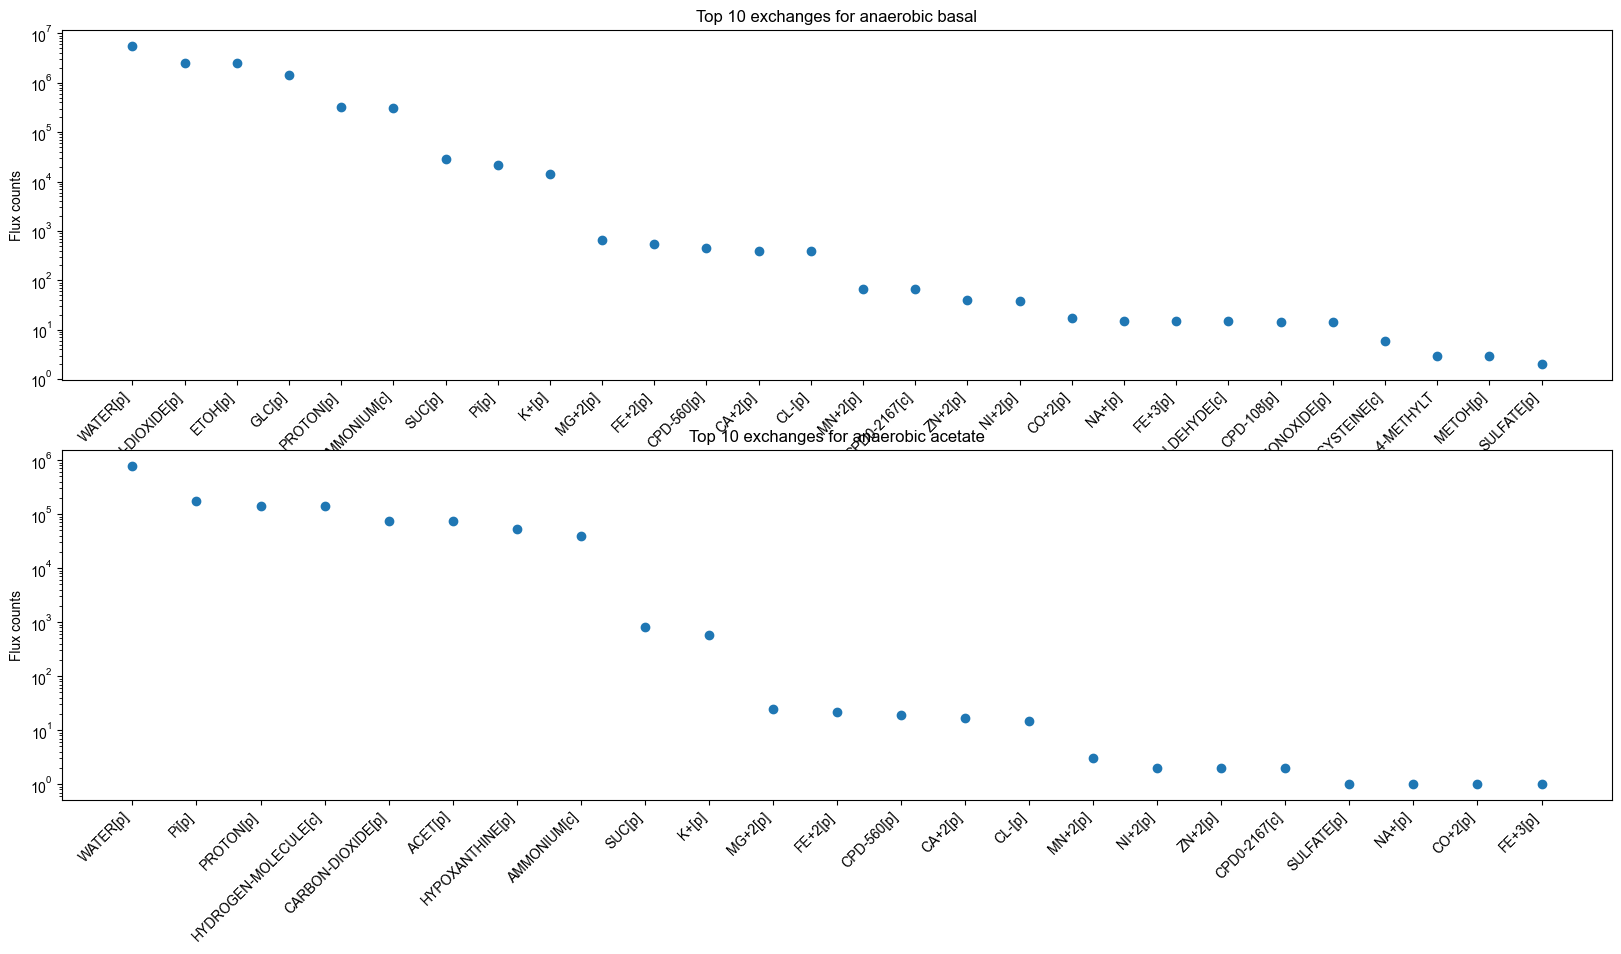

In [44]:
%matplotlib inline
# plot anaerobic basal and acetate exchanges
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
cur_exchanges = pd.Series(anaerobic_basal_exchanges, index=metabolism_basal.metabolite_names).abs().sort_values(ascending=False)
nonzero = len(cur_exchanges[cur_exchanges > 0])
ax[0].plot(cur_exchanges.head(nonzero), 'o')
ax[0].set_xticks([i for i in range(nonzero)], [i[:20] for i in cur_exchanges.index[:nonzero]], rotation=45, ha= 'right')
ax[0].set_yscale('log')
ax[0].set_ylabel('Flux counts')
ax[0].set_title('Top 10 exchanges for anaerobic basal')

cur_exchanges = pd.Series(anaerobic_acetate_exchanges, index=metabolism_acetate.metabolite_names).abs().sort_values(ascending=False)
nonzero = len(cur_exchanges[cur_exchanges > 0])
ax[1].plot(cur_exchanges.head(nonzero), 'o')
ax[1].set_xticks([i for i in range(nonzero)], [i[:20] for i in cur_exchanges.index[:nonzero]], rotation=45, ha= 'right')
ax[1].set_yscale('log')
ax[1].set_ylabel('Flux counts')
ax[1].set_title('Top 10 exchanges for anaerobic acetate')
# plt.show()


In [45]:
df_reaction_track['is_used'] = np.any(df_reaction_track[conditions], axis=1)
df_reaction_track['is_new'] = False
df_reaction_track['is_kinetic'] = False
df_reaction_flux['is_new'] = False
df_reaction_flux['is_kinetic'] = False

df_reaction_track.loc[fba_new_reaction_ids, 'is_new'] = True
df_reaction_track.loc[kinetic_reaction_ids, 'is_kinetic'] = True
df_reaction_flux.loc[fba_new_reaction_ids, 'is_new'] = True
df_reaction_flux.loc[kinetic_reaction_ids, 'is_kinetic'] = True

In [46]:
df_reaction_track.loc[df_reaction_track.is_new == True,:]

,basal,acetate,rich,anaerobic_basal,anaerobic_acetate,anaerobic_rich,is_used,is_new,is_kinetic
1.1.1.271-RXN (reverse),False,False,False,False,False,False,False,True,False
1.11.1.15-RXN,False,False,False,False,False,False,False,True,False
1.13.11.16-RXN,False,False,False,False,False,False,False,True,True
1.97.1.4-A-RXN,False,False,False,False,False,False,False,True,False
1PFRUCTPHOSN-RXN,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...
TREHALA-RXN[CCO-PERI-BAC]-TREHALOSE/WATER//GLC/ALPHA-GLUCOSE.49.,False,False,False,False,False,False,False,True,True
UDPMANACATRANS-RXN,False,False,False,False,False,False,False,True,False
UDPMANNACADEHYDROG-RXN,False,False,False,False,False,False,False,True,False
UNDECAPRENYL-DIPHOSPHATASE-RXN[CCI-PERI-BAC-GN]-UNDECAPRENYL-DIPHOSPHATE/WATER//CPD-9646/Pi/PROTON.68.,False,False,False,False,False,False,False,True,False


In [47]:
anaerobic_basal_velocities_df = pd.DataFrame(anaerobic_basal_velocities, index=reaction_names, columns=['anaerobic_basal'])
anaerobic_acetate_velocities_df = pd.DataFrame(anaerobic_acetate_velocities, index=reaction_names, columns=['anaerobic_acetate'])
no_ammonia_velocities_df = pd.DataFrame(no_ammonia_velocities, index=reaction_names, columns=['no_ammonia'])
anaerobic_nitric_oxide_velocities_df = pd.DataFrame(anaerobic_nitric_oxide_velocities, index=reaction_names, columns=['anaerobic_nitric_oxide'])

In [48]:
S = metabolism_basal.stoichiometry.copy()

### instead of tracking reactions, track gene usage. 
i.e. map reactions to enzyme, then enzyme to genes.

In [49]:
NOTEBOOK_DIR = f'notebooks/Heena notebooks/Metabolism_New Genes'
def string_to_list(s):
    try:
        return np.array(ast.literal_eval(s))  # Safely convert string to list
    except (ValueError, SyntaxError):
        return np.array(s)  # Return as-is if conversion fails (e.g., NaN values)

def get_keys(dict, value):
    return [key for key in dict if dict[key] == value]

metabolic_gene_annotation = pd.read_csv(os.path.join(NOTEBOOK_DIR, "new_metabolic_gene_annotation.csv"), converters={'Reactions': string_to_list})
all_metabolic_gene_annotation = pd.read_csv(os.path.join(NOTEBOOK_DIR, "all_metabolic_gene_annotation.csv"), converters={'Reactions': string_to_list})

df_gene_usage = metabolic_gene_annotation.loc[:,['Enzyme encoded', 'Reactions']]
df_gene_usage.set_index(metabolic_gene_annotation['Gene ID (EcoCyc)'], inplace=True)

df_all_gene_usage = all_metabolic_gene_annotation.loc[:,['Enzyme encoded', 'Reactions']]
df_all_gene_usage.set_index(all_metabolic_gene_annotation['Gene ID (EcoCyc)'], inplace=True)

In [50]:
reaction_catalysts = metabolism_basal.parameters["reaction_catalysts"]
new_genes = metabolic_gene_annotation['Gene ID (EcoCyc)']
genes_to_enzymes = all_metabolic_gene_annotation.set_index('Gene ID (EcoCyc)')['Enzyme encoded'].to_dict()
conditions = ['basal', 'acetate', 'rich', 'anaerobic_basal', 'anaerobic_acetate', 'anaerobic_rich']

df_gene_usage['has_kinetic'] = False
df_all_gene_usage['has_kinetic'] = False

# len(reaction_names)
# basal_new_reaction_usage = df_reaction_track.loc[fba_new_reaction_ids,'basal']
for condition in conditions:
    df_gene_usage[condition] = 0
    df_all_gene_usage[condition] = 0
    new_reaction_usage = df_reaction_track.loc[fba_new_reaction_ids, condition]
    all_reaction_usage = df_reaction_track.loc[:,condition]
    for rxn in reaction_names:
        is_used = all_reaction_usage.loc[rxn]
        enzymes = reaction_catalysts.get(rxn,[])
        for enz in enzymes:
            enz = enz[:-3]
            genes = get_keys(genes_to_enzymes, enz)
            for gene in genes:
                if is_used:
                    df_all_gene_usage.loc[gene, condition] += 1
                if rxn in kinetic_reaction_ids:
                    df_all_gene_usage.loc[gene, 'has_kinetic'] = True
            

# tally usage
df_all_gene_usage['is_used'] = np.any(df_all_gene_usage[conditions] > 0, axis=1)
df_gene_usage = df_all_gene_usage.loc[new_genes, :]

In [51]:
sum(df_gene_usage['is_used'])

14

## focus on new genes with kinetics but not used across any simulated conditions so far

In [52]:
unused_kinetic_gene = df_gene_usage[(df_gene_usage.has_kinetic) & (~df_gene_usage.is_used)]
unused_kinetic_gene

,Enzyme encoded,Reactions,has_kinetic,basal,acetate,rich,anaerobic_basal,anaerobic_acetate,anaerobic_rich,is_used
Gene ID (EcoCyc),,,,,,,,,,
EG10033,GLUCOSE-1-PHOSPHAT-CPLX,"[GLUCOSE-1-PHOSPHAT-RXN, RXN0-1001]",True,0,0,0,0,0,0,False
G6286,CPLX0-7993,[RXN0-7024],True,0,0,0,0,0,0,False
EG11531,CFA-CPLX,[2.1.1.79-RXN],True,0,0,0,0,0,0,False
EG11105,CPLX0-7766,"[RXN0-7105, RXN0-7046]",True,0,0,0,0,0,0,False
EG10369,GLUCDEHYDROG-MONOMER,[RXN0-6373],True,0,0,0,0,0,0,False
EG11871,GPH-MONOMER,[GPH-RXN],True,0,0,0,0,0,0,False
G7445,GLUCARDEHYDRA-MONOMER,"[GLUCARDEHYDRA-RXN, RXN0-5285]",True,0,0,0,0,0,0,False
EG10456,EG10456-MONOMER,"[R621-RXN, 1.5.1.34-RXN]",True,0,0,0,0,0,0,False
G6932,G6932-MONOMER,"[SORBITOL-6-PHOSPHATASE-RXN, MANNITOL-1-PHOSPH...",True,0,0,0,0,0,0,False


In [53]:
# Connect to Ecocyc API
s = requests.Session() # create session
# Post login credentials to session:
s.post('https://websvc.biocyc.org/credentials/login/', data={'email':'cellulararchitect@protonmail.com', 'password':'Cellman0451'})

<Response [200]>

In [54]:
from ontologize.ontology import build_ontology, get_ontology_data
import networkx as nx

gene_id = unused_kinetic_gene.index

# ont = build_ontology(objects=gene_id, schema_type="Gene")
# 
# assert isinstance(ont.graph, nx.DiGraph)
# 
# print(ont.to_string(max_depth=None, include_leaves=False, colors=True))
# 

ont = build_ontology(objects=["EG10131", "EG10524", "EG11074"], schema_type="Gene", session=s)
assert isinstance(ont.graph, nx.DiGraph)
print(ont.to_string(max_depth=None, include_leaves=False, colors=True))

ModuleNotFoundError: No module named 'ontologize'

In [ ]:
# Assuming ont.graph is a NetworkX DiGraph
G = ont.graph
common_names, parents_dict = get_ontology_data(objects=gene_id, schema_type="Gene")
# Extract parent-child relationships
edges = list(G.edges)
nodes = list(G.nodes)

# Create parent-child mapping
data = []
for parent, child in edges:
    #if parent starts with "BC", common_names[parent] will be the parent name
    if parent.startswith("BC"):
        parent = common_names[parent]
    if child.startswith("BC"):
        child = common_names[child]
    data.append([child, parent])  # child → parent relationship

# Convert to DataFrame
df = pd.DataFrame(data, columns=["category", "parent"])

# Count occurrences of each category (to determine size)
df_size = df["parent"].value_counts().reset_index()
df_size.columns = ["category", "size"]

# Merge sizes into the main DataFrame
df = df.merge(df_size, on="category", how="left")
df["size"] = df["size"].fillna(1)  # If a node has no children, assign size = 1

# Create the Sunburst Plot
fig = px.sunburst(
    df,
    names="category",
    parents="parent",
    values="size",
    title="Automated Starburst Plot from Ontology Graph",
    template="plotly",
)

# Show Figure
fig.show(renderer='browser')

# Store variables across notebooks

In [56]:
%store df_reaction_flux df_reaction_track df_gene_usage genes_to_enzymes df_all_gene_usage new_genes unused_kinetic_gene

Stored 'df_reaction_flux' (DataFrame)
Stored 'df_reaction_track' (DataFrame)
Stored 'df_gene_usage' (DataFrame)
Stored 'genes_to_enzymes' (dict)
Stored 'df_all_gene_usage' (DataFrame)
Stored 'new_genes' (Series)
Stored 'unused_kinetic_gene' (DataFrame)


# Scratch

In [ ]:
s = requests.Session() # create session
# Post login credentials to session:
s.post('https://websvc.biocyc.org/credentials/login/', data={'email':'cellulararchitect@protonmail.com', 'password':'Cellman0451'})

In [ ]:
req_func = f"https://websvc.biocyc.org/apixml?fn=enzymes-of-gene&id=ECOLI:EG11658&detail=full"
# response_func = s.get(req_func)
# xmltodict.parse(response_func.content)['ptools-xml']['Gene']

In [ ]:
response_func = s.get(req_func)
response_func.status_code

In [ ]:
xmltodict.parse(response_func.content)['ptools-xml'].keys()